In [2]:
import os, time  # Only if file operations are needed
print(os.getcwd())  # Check current working directory


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
import sys


os.chdir('/Users/doma/Documents/Bachelor_Arbeit/Code') # Change to the directory where the code is located
print(os.getcwd())  # Confirm it changed
import importlib
import src.utils as utils

# Reload the module to reflect the latest changes or RESTART the KERNEL
importlib.reload(utils)

# Now you should see the updated functions
print(dir(utils))

/Users/doma/Documents/Bachelor_Arbeit/Code
/Users/doma/Documents/Bachelor_Arbeit/Code
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'compute_highlight_regions', 'group_by_pred_class', 'os', 'pd', 'save_csv_no_overwrite']


## Processing ESM and Alpha Data together through same pipeline

In [4]:
# Collect all the data in one .csv file
# Load the CPP Profile Predicted 1534 proteins .csv
df_predicted = pd.read_csv('/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/Human_N_Out_Proteome.csv')

# Drop redundant columns
df_predicted = df_predicted.drop(columns=['organism','human_n-out_proteome','topology','tmd_AN'])
df_predicted.head(5)

,entry,name,gene_name,PRED_MEAN [%],PRED_STD [%],dataset,class,pred_class,new_hc_substrate,substrate_homolog,...,sheddase,length,len_signal_pep,len_top_n,len_tmd,len_top_c,jmd_n,tmd,jmd_c,len_tmd_AN
0,P16150,LEUK_HUMAN,SPN,95.22,2.02,SUBEXPERT,SS_TYPE1,HC substrate,0,1,...,NaN,400,19,234,23,124,PFRNPDENSR,GMLPVAVLVALLAVIVLVALLLL,WRRRQKRRTG,23
1,P28827,PTPRM_HUMAN,PTPRM,94.79,2.09,SUBEXPERT,SS_TYPE1,HC substrate,0,1,...,BACE1,1452,20,722,22,688,PEKQTDHTVK,IAGVIAGILLFVIIFLGVVLVM,KKRKLAKKRK,22
2,P10586,PTPRF_HUMAN,PTPRF,94.64,2.03,SUBEXPERT,SS_TYPE1,HC substrate,0,1,...,NaN,1907,29,1234,21,623,QQQEEPEMLW,VTGPVLAVILIILIVIAILLF,KRKRTHSPSS,21
3,Q06418,TYRO3_HUMAN,TYRO3,94.49,2.14,SUBEXPERT,SS_TYPE1,HC substrate,0,1,...,NaN,890,40,389,21,440,QGPPHSRTSW,VPVVLGVLTALVTAAALALIL,LRKRRKETRF,21
4,P54764,EPHA4_HUMAN,EPHA4,94.39,2.26,SUBEXPERT,SS_TYPE1,HC substrate,0,1 (D3ZZK3_RAT),...,ADAM10;BACE1,986,19,528,22,417,RIIGDGANST,VLLVSVSGSVVLVVILIAAFVI,SRRRSKYSKA,22


In [5]:
# Here are all proteins stored
alpha_path = '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/AlphaMissense_mean_csv'
# P05067 + '_avg.csv'
esm_path = '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/ESM_mean_csv'
# P05067 + '_mean_LLR.csv


In [102]:
protein_id = 'P05067'
mean_pathway = '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed'
result = utils.compute_highlight_regions(
    'AlphaMissense',  
    protein_id, 
    mean_pathway,  
    df_predicted, 
    TMD_region='11AA',
    rolling_average=1
)


print(result["highlight_start"], result["highlight_end"])
print(result["TMD_start"], result["TMD_end"])
print(result['average_cleavage_region'])
result['protein_data'].head(10)



716 726
702 722
0.8491535885167463


,residue_position,residue,residue_pathogenicity,category,smoothed_pathogenicity
0,1,M,0.375658,ambiguous,0.375658
1,2,L,0.161847,likely benign,0.161847
2,3,P,0.198663,likely benign,0.198663
3,4,G,0.167674,likely benign,0.167674
4,5,L,0.191600,likely benign,0.191600
5,6,A,0.286926,likely benign,0.286926
6,7,L,0.218174,likely benign,0.218174
7,8,L,0.225258,likely benign,0.225258
8,9,L,0.225637,likely benign,0.225637
9,10,L,0.211874,likely benign,0.211874


### Assign average pathogenicity scores of 11AA and 40AA to Human_N_Out_proteome.csv

In [9]:
mean_pathway = '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed'
TMD_region = '40AA'         # '11AA' or '40AA'
model = 'ESM1b'             # 'AlphaMissense' or 'ESM1b'

i=1
for protein_id in df_predicted['entry']:

    # get all the data for each protein with this function storing them in dictionary 'result'
    result = utils.compute_highlight_regions(
        model,  
        protein_id, 
        mean_pathway,  
        df_predicted, 
        TMD_region,
        rolling_average=1
    )

    # Assign correct columns to the human_N_out_proteome.csv
    average_name = 'avg_pathogenicity_' + TMD_region +'_' + model

    if TMD_region == '11AA':
        start_name = 'Start_' + TMD_region
        end_name = 'End_' + TMD_region
    elif TMD_region == '40AA':
        start_name = 'Start_' + TMD_region
        end_name = 'End_' + TMD_region
    
    # Append the results to the dataframe
    df_predicted.loc[df_predicted['entry'] == protein_id, start_name] = result["highlight_start"]
    df_predicted.loc[df_predicted['entry'] == protein_id, end_name] = result["highlight_end"]
    df_predicted.loc[df_predicted['entry'] == protein_id, 'TMD_start'] = result["TMD_start"]
    df_predicted.loc[df_predicted['entry'] == protein_id, 'TMD_end'] = result["TMD_end"]
    df_predicted.loc[df_predicted['entry'] == protein_id, average_name] = result['average_cleavage_region']


print("All proteins were assigned successfully.")

File /Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/ESM_mean_csv/P0DSE2_mean_LLR.csv does not exist.
File /Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/ESM_mean_csv/Q92813_mean_LLR.csv does not exist.
File /Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/ESM_mean_csv/P49895_mean_LLR.csv does not exist.
File /Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/ESM_mean_csv/Q9BQE4_mean_LLR.csv does not exist.
File /Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/ESM_mean_csv/Q9Y6D0_mean_LLR.csv does not exist.
File /Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/ESM_mean_csv/P62341_mean_LLR.csv does not exist.
All proteins were assigned successfully.


In [10]:
# Save the updated DataFrame to a new CSV file
output_path = '/Users/doma/Documents/Bachelor_Arbeit/Code/results/csv/Human_N_Out_Proteome_TMD_pathogenicity.csv'
utils.save_csv_no_overwrite(df_predicted, output_path)

Saved to /Users/doma/Documents/Bachelor_Arbeit/Code/results/csv/Human_N_Out_Proteome_TMD_pathogenicity_3.csv


### Question: What now?
- First make a statistical analysis of the four groups.
- Second Define function to plot the average pathogenicities across the TMD region

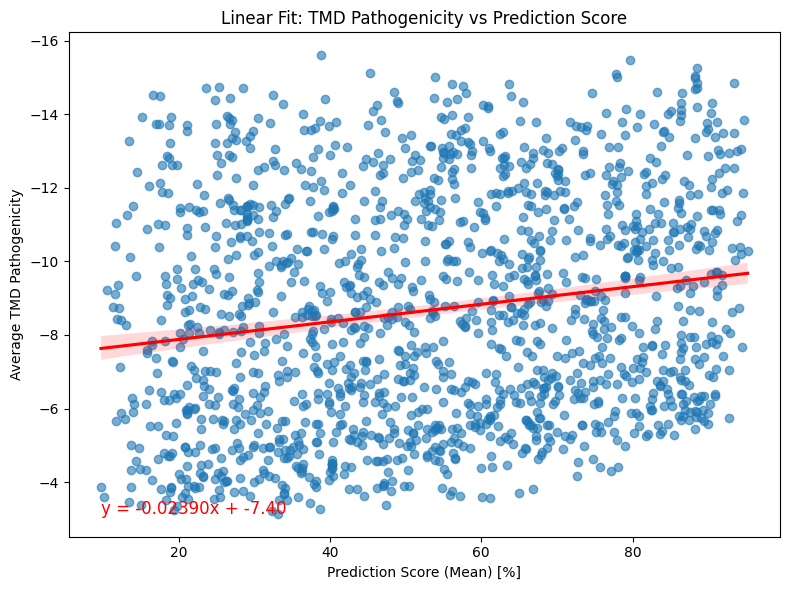

In [15]:
# Drop rows with NaN or infinite values in x1 or y1
df_predicted = pd.read_csv(output_path)
valid_data = df_predicted[["PRED_MEAN [%]", "avg_pathogenicity_11AA_ESM1b"]].dropna()
x1 = valid_data["PRED_MEAN [%]"]
y1 = valid_data["avg_pathogenicity_11AA_ESM1b"]

# Linear regression
slope, intercept = np.polyfit(x1, y1, 1)
regression_eq = f"y = {slope:.5f}x + {intercept:.2f}"

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(x=x1, y=y1, scatter_kws={'alpha':0.6}, line_kws={"color": "red"})
plt.gca().invert_yaxis()  # Reverse the y-axis
plt.xlabel("Prediction Score (Mean) [%]")
plt.ylabel("Average TMD Pathogenicity")
plt.title("Linear Fit: TMD Pathogenicity vs Prediction Score")
plt.text(x1.min(), y1.max(), regression_eq, fontsize=12, color="red")  # equation on plot
plt.tight_layout()
plt.show()

/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_8797/337845505.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_8797/337845505.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


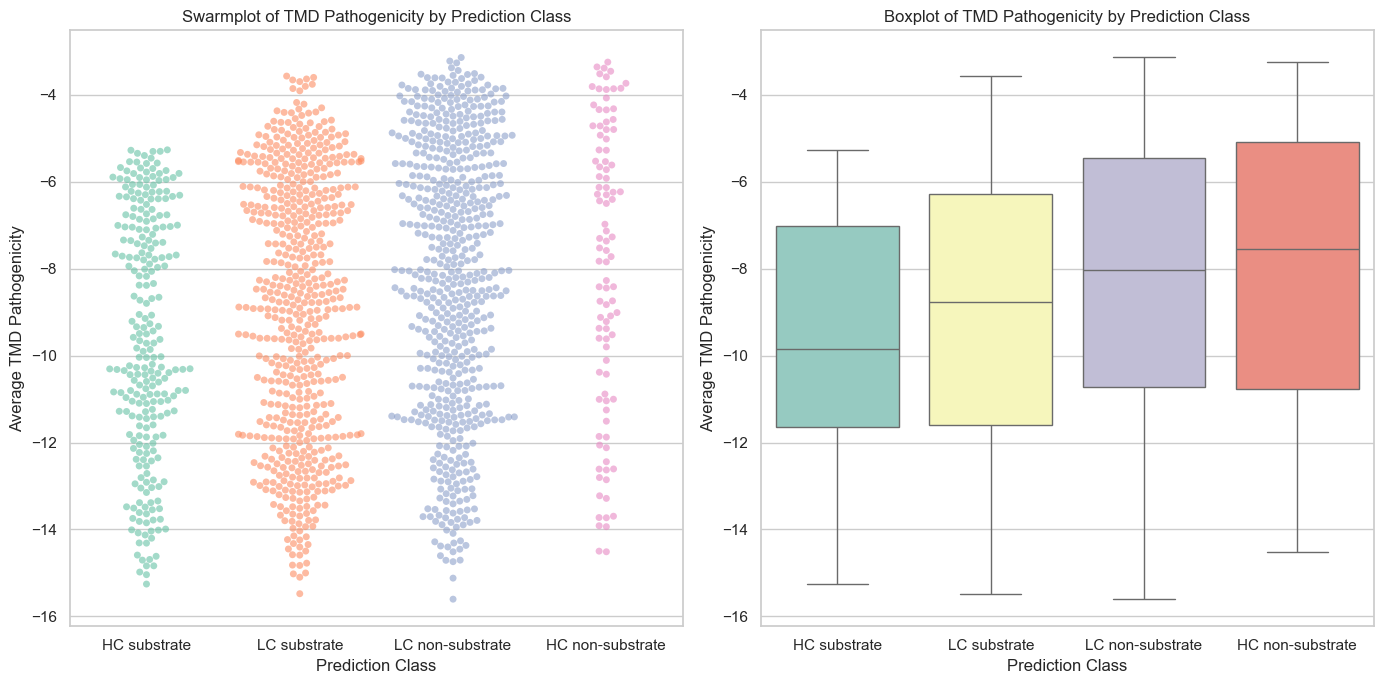

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the data is loaded into df_predicted and contains the required columns:
# 'PRED_MEAN [%]', 'avg_pathogenicity_11AA_ESM1b', and 'pred_class'

# Step 1: Set up the figure and style
plt.figure(figsize=(14, 7))  # Create a figure with a larger size for better visualization
sns.set(style="whitegrid")  # Use a clean grid style for the plots

# Step 2: Create the Swarmplot
plt.subplot(1, 2, 1)  # Create the first subplot (1 row, 2 columns, 1st plot)
sns.swarmplot(
    x="pred_class",  # Group data by the 'pred_class' column
    y="avg_pathogenicity_11AA_ESM1b",  # Plot the average pathogenicity on the y-axis
    data=df_predicted,  # Use the df_predicted DataFrame
    alpha=0.6,  # Set transparency for the points
    palette="Set2"  # Use a color palette for better distinction
)
plt.title("Swarmplot of TMD Pathogenicity by Prediction Class")  # Add a title
plt.xlabel("Prediction Class")  # Label for the x-axis
plt.ylabel("Average TMD Pathogenicity")  # Label for the y-axis

# Step 3: Create the Boxplot
plt.subplot(1, 2, 2)  # Create the second subplot (1 row, 2 columns, 2nd plot)
sns.boxplot(
    x="pred_class",  # Group data by the 'pred_class' column
    y="avg_pathogenicity_11AA_ESM1b",  # Plot the average pathogenicity on the y-axis
    data=df_predicted,  # Use the df_predicted DataFrame
    palette="Set3"  # Use a different color palette for the boxplot
)
plt.title("Boxplot of TMD Pathogenicity by Prediction Class")  # Add a title
plt.xlabel("Prediction Class")  # Label for the x-axis
plt.ylabel("Average TMD Pathogenicity")  # Label for the y-axis

# Step 4: Adjust layout and display the plots
plt.tight_layout()  # Adjust spacing between subplots to prevent overlap
plt.show()  # Display the plots

/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_8797/337845505.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_8797/337845505.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


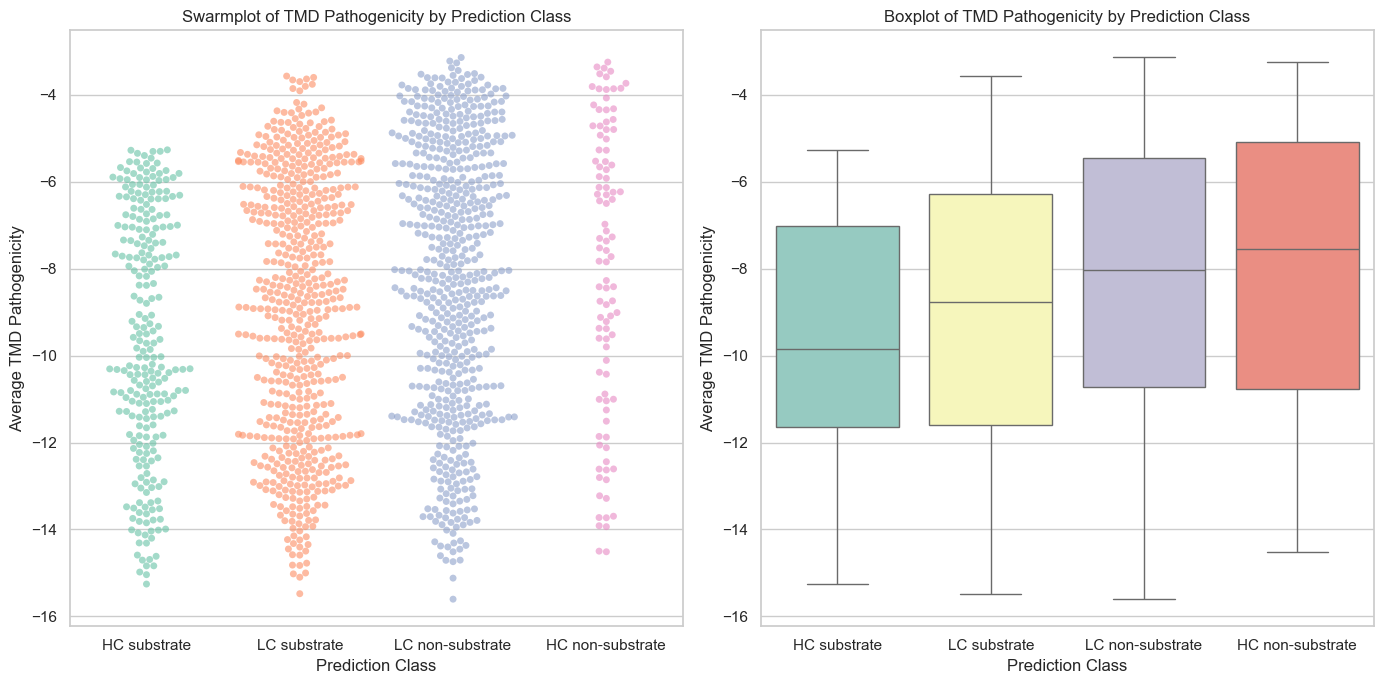

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the data is loaded into df_predicted and contains the required columns:
# 'PRED_MEAN [%]', 'avg_pathogenicity_11AA_ESM1b', and 'pred_class'

# Step 1: Set up the figure and style
plt.figure(figsize=(14, 7))  # Create a figure with a larger size for better visualization
sns.set(style="whitegrid")  # Use a clean grid style for the plots

# Step 2: Create the Swarmplot
plt.subplot(1, 2, 1)  # Create the first subplot (1 row, 2 columns, 1st plot)
sns.swarmplot(
    x="pred_class",  # Group data by the 'pred_class' column
    y="avg_pathogenicity_11AA_ESM1b",  # Plot the average pathogenicity on the y-axis
    data=df_predicted,  # Use the df_predicted DataFrame
    alpha=0.6,  # Set transparency for the points
    palette="Set2"  # Use a color palette for better distinction
)
plt.title("Swarmplot of TMD Pathogenicity by Prediction Class")  # Add a title
plt.xlabel("Prediction Class")  # Label for the x-axis
plt.ylabel("Average TMD Pathogenicity")  # Label for the y-axis

# Step 3: Create the Boxplot
plt.subplot(1, 2, 2)  # Create the second subplot (1 row, 2 columns, 2nd plot)
sns.boxplot(
    x="pred_class",  # Group data by the 'pred_class' column
    y="avg_pathogenicity_11AA_ESM1b",  # Plot the average pathogenicity on the y-axis
    data=df_predicted,  # Use the df_predicted DataFrame
    palette="Set3"  # Use a different color palette for the boxplot
)
plt.title("Boxplot of TMD Pathogenicity by Prediction Class")  # Add a title
plt.xlabel("Prediction Class")  # Label for the x-axis
plt.ylabel("Average TMD Pathogenicity")  # Label for the y-axis

# Step 4: Adjust layout and display the plots
plt.tight_layout()  # Adjust spacing between subplots to prevent overlap
plt.show()  # Display the plots

NameError: name 'posthoc' is not defined

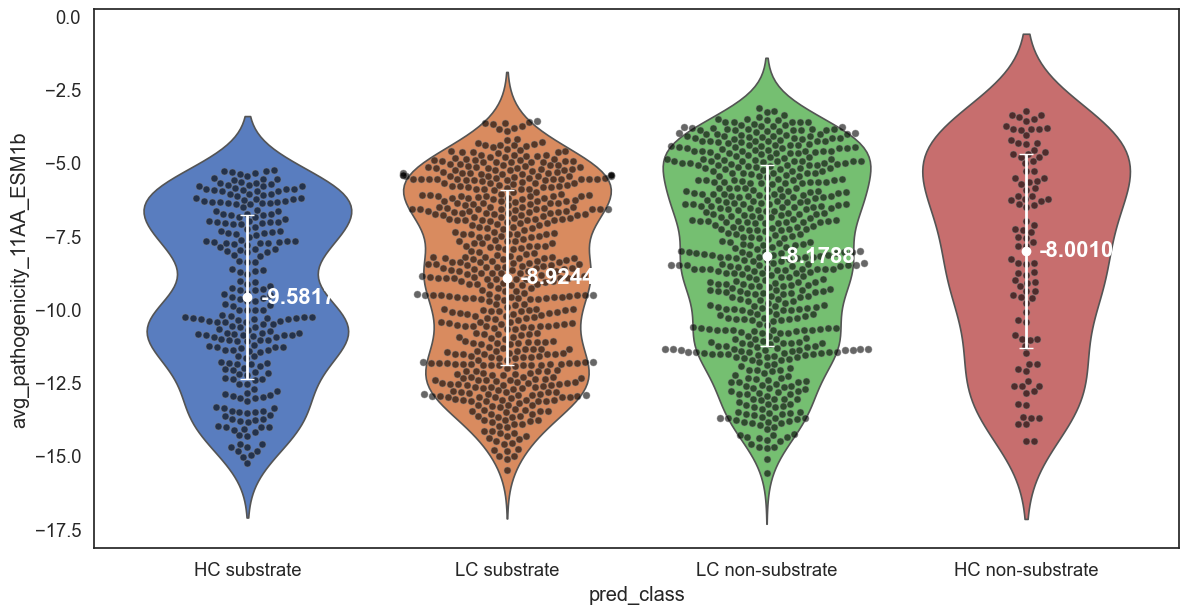

In [146]:
# Ensure correct category order
order = ['HC substrate', 'LC substrate', 'LC non-substrate', 'HC non-substrate']
df_predicted['pred_class'] = pd.Categorical(
    df_predicted['pred_class'], categories=order, ordered=True
)

# Compute mean and std
stats_df = df_predicted.groupby('pred_class', observed=True)['avg_pathogenicity_11AA_ESM1b'].agg(['mean', 'std'])

# Plot
sns.set(style="white", context="notebook", font_scale=1.2)
plt.figure(figsize=(14, 7))

# Violin plot
sns.violinplot(
    x='pred_class', 
    y='avg_pathogenicity_11AA_ESM1b', 
    hue='pred_class', 
    data=df_predicted, 
    inner=None, 
    order=order, 
    palette="muted", 
    linewidth=1.2,
    legend=False
)

# Swarm plot
sns.swarmplot(
    x='pred_class', 
    y='avg_pathogenicity_11AA_ESM1b', 
    data=df_predicted, 
    color='black', 
    alpha=0.6,
    size=5, 
    order=order,
    edgecolor='0.5',
    linewidth=0.5
)

# Plot mean ± std
for i, cls in enumerate(order):
    mean = stats_df.loc[cls, 'mean']
    std = stats_df.loc[cls, 'std']
    plt.errorbar(i, mean, yerr=std, fmt='o', color='white', capsize=5, lw=2, zorder=4)
    plt.text(i + 0.05, mean, f"{mean:.4f}", ha='left', va='center',
         fontsize=16, color='white', weight='bold', zorder=5)

# Significance lines (based on your posthoc matrix)
def get_significance_symbol(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    return None

# Example posthoc matrix (replace with your actual posthoc matrix)
# posthoc = pd.read_csv('path_to_posthoc.csv', index_col=0)

y_max = df_predicted['avg_pathogenicity_11AA_ESM1b'].max()
line_height = y_max + 0.02
increment = 0.03
comparisons = [
    ('HC substrate', 'HC non-substrate'),
    ('HC substrate', 'LC substrate'),
    ('HC substrate', 'LC non-substrate'),
    ('LC substrate', 'HC non-substrate'),
    ('LC non-substrate', 'HC non-substrate'),
    ('LC substrate', 'LC non-substrate')
]

for i, (group1, group2) in enumerate(comparisons):
    p_val = posthoc.loc[group1, group2] if group1 in posthoc.index and group2 in posthoc.columns else posthoc.loc[group2, group1]
    symbol = get_significance_symbol(p_val)
    if symbol:
        x1, x2 = order.index(group1), order.index(group2)
        y = line_height + i * increment
        plt.plot([x1, x1, x2, x2], [y, y + 0.01, y + 0.01, y], lw=1.5, color='k')
        plt.text((x1 + x2) / 2, y + 0.015, symbol, ha='center', va='bottom', color='k', fontsize=14)

# Final plot styling
plt.title('Average Pathogenicity of TMD Regions per Prediction Class', fontsize=18, weight='bold')
plt.xlabel('', fontsize=14)
plt.ylabel('Average TMD Pathogenicity', fontsize=14)
plt.xticks(rotation=0, fontsize=13, weight='bold')
plt.yticks(fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot (optional)
#plt.savefig('/Users/doma/Documents/Bachelor Arbeit/1.Task_BA/df_predicted_violinplot_pred_classes.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [3]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Ensure correct category order
order = ['HC substrate', 'LC substrate', 'LC non-substrate', 'HC non-substrate']
df_predicted['pred_class'] = pd.Categorical(
    df_predicted['pred_class'], categories=order, ordered=True
)

# Compute mean and standard deviation for each group
stats_df = df_predicted.groupby('pred_class', observed=True)['avg_pathogenicity_11AA_ESM1b'].agg(['mean', 'std'])






# Create the violin plot
fig = go.Figure()

# Add violin plots for each category
for cls in order:
    fig.add_trace(go.Violin(
        x=df_predicted.loc[df_predicted['pred_class'] == cls, 'pred_class'],
        y=df_predicted.loc[df_predicted['pred_class'] == cls, 'avg_pathogenicity_11AA_ESM1b'],
        name=cls,
        box_visible=True,  # Show box inside the violin
        meanline_visible=True,  # Show mean line
        line_color='rgba(58, 71, 80, 0.8)',  # Line color for the violin
        fillcolor='rgba(58, 71, 80, 0.3)',  # Fill color for the violin
        opacity=0.7
    ))

# Add swarm points (scatter points) for each category
for cls in order:
    fig.add_trace(go.Scatter(
        x=df_predicted.loc[df_predicted['pred_class'] == cls, 'pred_class'],
        y=df_predicted.loc[df_predicted['pred_class'] == cls, 'avg_pathogenicity_11AA_ESM1b'],
        mode='markers',
        name=f'{cls} Points',
        marker=dict(
            color='red',
            size=6,
            opacity=0.6,
            line=dict(width=0.5, color='white')  # Add a white border around points
        ),
        showlegend=False  # Hide legend for swarm points
    ))

# Add mean ± std as error bars
for i, cls in enumerate(order):
    mean = stats_df.loc[cls, 'mean']
    std = stats_df.loc[cls, 'std']
    fig.add_trace(go.Scatter(
        x=[cls],
        y=[mean],
        mode='markers+text',
        name=f'{cls} Mean ± Std',
        error_y=dict(
            type='data',
            array=[std],
            visible=True,
            thickness=1.5,
            width=5,
            color='black'
        ),
        marker=dict(
            color='white',
            size=10,
            line=dict(width=2, color='black')
        ),
        text=[f"{mean:.4f}"],
        textposition="top center",
        textfont=dict(
            size=12,
            color='black'
        ),
        showlegend=False  # Hide legend for mean ± std
    ))

# Reverse the y-axis
fig.update_yaxes(
    title_text="Average TMD Pathogenicity",
    autorange="reversed",  # Reverse the y-axis
    showgrid=True,
    gridcolor='rgba(200, 200, 200, 0.5)',  # Light gridlines
    zeroline=True,
    zerolinecolor='rgba(0, 0, 0, 0.5)',  # Darker zero line
    zerolinewidth=1.5
)

# Update x-axis
fig.update_xaxes(
    title_text="Prediction Class",
    showgrid=False,
    tickangle=0,
    tickfont=dict(size=12, color='black')
)

# Update layout for a professional look
fig.update_layout(
    title=dict(
        text="Average Pathogenicity of TMD Regions per Prediction Class",
        font=dict(size=18, color='black', family="Arial"),
        x=0.5,  # Center the title
        xanchor='center'
    ),
    legend=dict(
        title="Legend",
        font=dict(size=12, color='black'),
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    margin=dict(l=50, r=50, t=80, b=50),  # Adjust margins
    plot_bgcolor='white',  # White background
    height=600,  # Height of the plot
    width=1000  # Width of the plot
)

# Show the plot
fig.show()

NameError: name 'df_predicted' is not defined

In [153]:
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import f_oneway  # For ANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd  # For post-hoc testing

# Ensure correct category order
order = ['HC substrate', 'LC substrate', 'LC non-substrate', 'HC non-substrate']
df_predicted['pred_class'] = pd.Categorical(
    df_predicted['pred_class'], categories=order, ordered=True
)

# Statistical Testing
anova_result = f_oneway(
    df[df['Group'] == 'HC substrate']['Score'],
    df[df['Group'] == 'LC substrate']['Score'],
    df[df['Group'] == 'LC non-substrate']['Score'],
    df[df['Group'] == 'HC non-substrate']['Score']
)
print(f"ANOVA p-value: {anova_result.pvalue}")

# Post-hoc testing (Tukey HSD)
tukey = pairwise_tukeyhsd(df['Score'], df['Group'])
print(tukey)

# Create the violin plot
fig = go.Figure()

# Add violins for each group
for group in group_order:
    fig.add_trace(go.Violin(
        x=df[df['Group'] == group]['Group'],
        y=df[df['Group'] == group]['Score'],
        name=group,
        box_visible=True,  # Show box inside the violin
        meanline_visible=True,  # Show mean line
        points="all",  # Show all points
        jitter=0.5,  # Add jitter for better visibility
        scalemode="count",  # Scale violins by the number of observations
        line_color="rgba(58, 71, 80, 0.8)",  # Line color for the violin
        fillcolor="rgba(58, 71, 80, 0.3)",  # Fill color for the violin
        opacity=0.7
    ))

# Add significance bars manually
significance_annotations = [
    {'x1': 'A', 'x2': 'B', 'p_value': 0.01},
    {'x1': 'A', 'x2': 'C', 'p_value': 0.001},
    {'x1': 'B', 'x2': 'D', 'p_value': 0.05}
]

y_max = df['Score'].max()
line_height = y_max + 0.05
increment = 0.05

for i, annotation in enumerate(significance_annotations):
    x1, x2 = annotation['x1'], annotation['x2']
    p_value = annotation['p_value']
    symbol = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
    if symbol:
        fig.add_shape(
            type="line",
            x0=group_order.index(x1),
            x1=group_order.index(x2),
            y0=line_height + i * increment,
            y1=line_height + i * increment,
            line=dict(color="black", width=1.5)
        )
        fig.add_annotation(
            x=(group_order.index(x1) + group_order.index(x2)) / 2,
            y=line_height + i * increment + 0.02,
            text=symbol,
            showarrow=False,
            font=dict(size=14, color="black")
        )

# Reverse the y-axis
fig.update_yaxes(
    title_text="Score (Reversed)",
    autorange="reversed",  # Reverse the y-axis
    showgrid=True,
    gridcolor='rgba(200, 200, 200, 0.5)',  # Light gridlines
    zeroline=True,
    zerolinecolor='rgba(0, 0, 0, 0.5)',  # Darker zero line
    zerolinewidth=1.5
)

# Update x-axis
fig.update_xaxes(
    title_text="Group",
    showgrid=False,
    tickangle=0,
    tickfont=dict(size=12, color='black')
)

# Update layout for a professional look
fig.update_layout(
    title=dict(
        text="Violin Plot with Statistical Significance",
        font=dict(size=18, color='black', family="Arial"),
        x=0.5,  # Center the title
        xanchor='center'
    ),
    legend=dict(
        title="Legend",
        font=dict(size=12, color='black'),
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    margin=dict(l=50, r=50, t=80, b=50),  # Adjust margins
    plot_bgcolor='white',  # White background
    height=600,  # Height of the plot
    width=1000  # Width of the plot
)

# Show the plot
fig.show()

ANOVA p-value: nan
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B     0.25 0.0036  0.0966 0.4034   True
     A      C   0.3767 0.0002  0.2233 0.5301   True
     A      D   0.4767    0.0  0.3233 0.6301   True
     B      C   0.1267 0.1098 -0.0267 0.2801  False
     B      D   0.2267 0.0064  0.0733 0.3801   True
     C      D      0.1 0.2355 -0.0534 0.2534  False
---------------------------------------------------


/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_82709/3774915939.py:13: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.

